<a href="https://colab.research.google.com/github/SamGu-NRX/LSTM-Stock-Price-Prediction/blob/main/LSTM_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using LSTM with PyTorch



## 1. Installation of Necessary Libraries

Before we begin, ensure that all required libraries are installed. We'll use `yfinance` for data fetching and `PyTorch` for building the LSTM model. Additionally, we'll use `scikit-learn` for data preprocessing and evaluation.


In [20]:
# Install necessary libraries
!pip install yfinance torch torchvision scikit-learn


## 2. Importing Libraries

Import all the necessary libraries required for data fetching, preprocessing, model building, training, and evaluation.


In [21]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.optimize import minimize

# For reproducibility
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

## 3. Fetching Stock Data

We'll fetch historical stock data for selected tickers using the `yfinance` package. For this example, we'll use the following tickers:
- Apple Inc. (AAPL)
- Microsoft Corporation (MSFT)
- Alphabet Inc. (GOOG)
- Amazon.com Inc. (AMZN)
- Tesla Inc. (TSLA)

You can modify the list of tickers as per your requirements.


In [22]:
# Function to fetch stock data for a given ticker
def get_stock_data(ticker, start_date='2010-01-01'):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date)
    return stock_data

# List of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']

# Fetch data for each ticker
data = {ticker: get_stock_data(ticker) for ticker in tickers}

# Display the first few rows of AAPL data as an example
data['AAPL'].head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.429939,6.462174,6.398306,6.447412,493729600,0.0,0.0
2010-01-05 00:00:00-05:00,6.465187,6.495012,6.424515,6.458559,601904800,0.0,0.0
2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.0,0.0
2010-01-07 00:00:00-05:00,6.379327,6.386859,6.297985,6.344079,477131200,0.0,0.0
2010-01-08 00:00:00-05:00,6.335641,6.386856,6.298284,6.386253,447610800,0.0,0.0


## 4. Feature Engineering

We'll enhance the dataset by adding key financial ratios and technical indicators:
- **Price-to-Earnings (P/E) Ratio**: `Close` price divided by the rolling mean of `Close` over 12 days.
- **Return on Equity (ROE)**: Percentage change in `Close` price.
- **Debt-to-Equity (Debt-to-Equity)**: Placeholder calculated as `Close` divided by `Open`.
- **Moving Average Convergence Divergence (MACD)**: Difference between 12-day EMA and 26-day EMA.
- **Relative Strength Index (RSI)**: Momentum oscillator measuring the speed and change of price movements.


In [23]:
# Function to calculate key financial ratios
def calculate_ratios(stock_data):
    stock_data['P/E'] = stock_data['Close'] / stock_data['Close'].rolling(window=12).mean()  # Price-to-Earnings
    stock_data['P/E'] = stock_data['P/E'].clip(lower=0, upper=50)  # Cap P/E to remove extreme values

    stock_data['ROE'] = stock_data['Close'].pct_change() * 100  # Return on Equity
    stock_data['Debt-to-Equity'] = stock_data['Close'] / stock_data['Open']  # Placeholder for Debt-to-Equity
    return stock_data

# Function to add technical indicators (MACD and RSI)
def add_technical_indicators(stock_data):
    stock_data['12-day EMA'] = stock_data['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
    stock_data['26-day EMA'] = stock_data['Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA
    stock_data['MACD'] = stock_data['12-day EMA'] - stock_data['26-day EMA']  # MACD

    delta = stock_data['Close'].diff()  # Daily change in price
    gain = delta.where(delta > 0, 0)  # Positive gains
    loss = -delta.where(delta < 0, 0)  # Negative losses
    avg_gain = gain.rolling(window=14, min_periods=1).mean()  # Average gain over 14 days
    avg_loss = loss.rolling(window=14, min_periods=1).mean()  # Average loss over 14 days
    rs = avg_gain / avg_loss  # Relative Strength
    stock_data['RSI'] = 100 - (100 / (1 + rs))  # Relative Strength Index
    stock_data['RSI'] = stock_data['RSI'].clip(lower=0, upper=100)  # Clip RSI values to the valid range
    return stock_data

# Apply ratios and technical indicators to each stock
for ticker in tickers:
    stock_data = data[ticker]
    data[ticker] = add_technical_indicators(calculate_ratios(stock_data))

# Display the first few rows of AAPL data after feature engineering
data['AAPL'].head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,P/E,ROE,Debt-to-Equity,12-day EMA,26-day EMA,MACD,RSI
Date,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,6.429939,6.462174,6.398306,6.447412,493729600,0.0,0.0,NaN,NaN,1.002718,6.447412,6.447412,0.000000,NaN
2010-01-05 00:00:00-05:00,6.465187,6.495012,6.424515,6.458559,601904800,0.0,0.0,NaN,0.172884,0.998975,6.449127,6.448238,0.000889,100.000000
2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.0,0.0,NaN,-1.590629,0.984094,6.434773,6.441392,-0.006619,9.788125
2010-01-07 00:00:00-05:00,6.379327,6.386859,6.297985,6.344079,477131200,0.0,0.0,NaN,-0.184843,0.994475,6.420820,6.434184,-0.013364,8.872762
2010-01-08 00:00:00-05:00,6.335641,6.386856,6.298284,6.386253,447610800,0.0,0.0,NaN,0.664790,1.007989,6.415502,6.430634,-0.015132,31.776474


## 5. Data Visualization (Optional)

Visualize some of the technical indicators to understand their behavior.


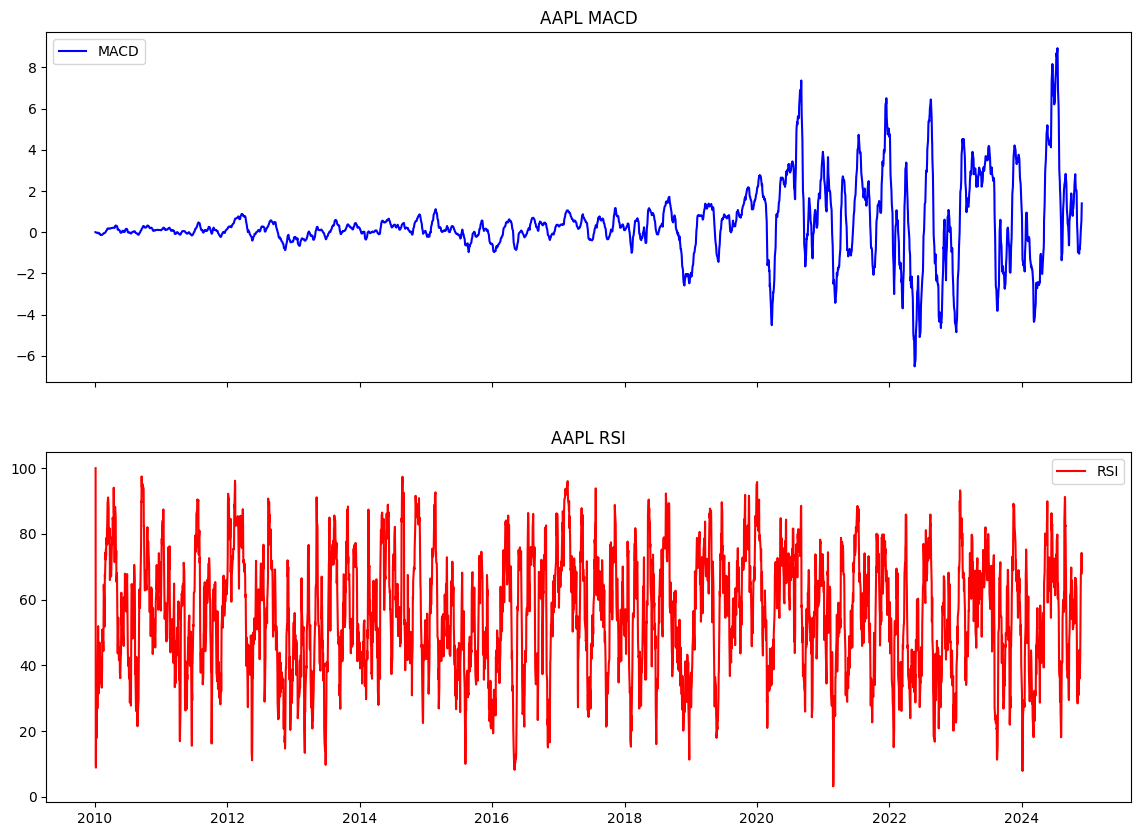

In [24]:
# Example: Plot MACD and RSI for AAPL
aapl_data = data['AAPL'].copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot MACD
axes[0].plot(aapl_data.index, aapl_data['MACD'], label='MACD', color='blue')
axes[0].set_title('AAPL MACD')
axes[0].legend()

# Plot RSI
axes[1].plot(aapl_data.index, aapl_data['RSI'], label='RSI', color='red')
axes[1].set_title('AAPL RSI')
axes[1].legend()

plt.show()


## 6. Preparing Data for Machine Learning

We'll prepare the dataset for the LSTM model by:
1. Defining the target variable as the next day's closing price.
2. Dropping rows with missing values.
3. Normalizing the feature columns using `RobustScaler`.
4. Splitting the data into training and testing sets.


In [56]:
# Prepare features and target
# Selecting a specific ticker for training (e.g., 'AAPL')
ticker = 'AAPL'
stock_data = data[ticker].copy()

# Define target as the next day's close price
stock_data['Target'] = stock_data['Close'].shift(-1)

# Add lag features for 1, 2, 3 days
for lag in range(1, 4):
    stock_data[f'Close_lag_{lag}'] = stock_data['Close'].shift(lag)

# Add rolling mean and standard deviation with a window of 7 days
stock_data['Rolling_mean_7'] = stock_data['Close'].rolling(window=7).mean()
stock_data['Rolling_std_7'] = stock_data['Close'].rolling(window=7).std()

# Replace infinite values and drop rows with NaN values after feature engineering
stock_data.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data.dropna(inplace=True)

# Define feature columns including the new lag and rolling features
features = ['P/E', 'ROE', 'Debt-to-Equity', 'MACD', 'RSI',
            'Close_lag_1', 'Close_lag_2', 'Close_lag_3',
            'Rolling_mean_7', 'Rolling_std_7']  # Updated feature list
target = 'Target'

# Initialize separate scalers for features and target
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

# Fit and transform features
stock_data[features] = feature_scaler.fit_transform(stock_data[features])

# Fit and transform target
stock_data['Target'] = target_scaler.fit_transform(stock_data[['Target']])

# Display the first few rows after normalization
stock_data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,P/E,ROE,Debt-to-Equity,12-day EMA,26-day EMA,MACD,RSI,Target,Close_lag_1,Close_lag_2,Close_lag_3,Rolling_mean_7,Rolling_std_7
Date,,,,,,,,,,,,,,,,,,,,
2010-01-20 00:00:00-05:00,6.474524,6.493805,6.311539,6.378722,612152800,0.0,0.0,-0.108002,-0.957041,-1.032051,6.364037,6.390540,-0.310338,-0.392379,-0.737238,-0.725379,-0.736737,-0.731000,-0.730048,-0.631325
2010-01-21 00:00:00-05:00,6.389269,6.426325,6.242552,6.268460,608154400,0.0,0.0,-0.506161,-1.067896,-1.309006,6.349333,6.381497,-0.320716,-0.580113,-0.750699,-0.729689,-0.724875,-0.735558,-0.730429,-0.623118
2010-01-22 00:00:00-05:00,6.229597,6.251288,5.939778,5.957552,881767600,0.0,0.0,-1.640202,-2.960000,-2.977062,6.289059,6.350094,-0.373646,-0.940823,-0.743760,-0.734455,-0.729185,-0.723695,-0.732295,-0.414804
2010-01-25 00:00:00-05:00,6.100954,6.166931,6.031060,6.117825,1065699600,0.0,0.0,-0.884918,1.519573,0.151015,6.262715,6.332889,-0.390400,-0.664649,-0.740017,-0.747895,-0.733950,-0.728005,-0.733714,-0.396439
2010-01-26 00:00:00-05:00,6.204593,6.438376,6.103066,6.204291,1867110000,0.0,0.0,-0.471494,0.771881,-0.038540,6.253727,6.323363,-0.389414,-0.554493,-0.737486,-0.740967,-0.747388,-0.732771,-0.734367,-0.401992


In [59]:
# # visualizing the dataset in google sheets

# from google.colab import sheets
# sheet = sheets.InteractiveSheet(df=stock_data)

print(train_data.describe())
print(val_data.describe())
print(test_data.describe())

print("Training Features Range:", train_data[features].min().min(), train_data[features].max().max())
print("Training Target Range:", train_data[target].min(), train_data[target].max())


              Open         High          Low        Close        Volume  \
count  2618.000000  2618.000000  2618.000000  2618.000000  2.618000e+03   
mean     27.303032    27.570627    27.045932    27.319906  2.931240e+08   
std      16.630625    16.837860    16.474507    16.674160  2.319838e+08   
min       5.795471     5.904830     5.731602     5.785830  4.544800e+07   
25%      14.337009    14.480932    14.213303    14.328304  1.240082e+08   
50%      23.244348    23.403399    23.092791    23.274529  2.124096e+08   
75%      37.436601    37.726851    37.053508    37.452598  3.980879e+08   
max      85.093132    86.423209    84.308733    85.953056  1.880998e+09   

         Dividends  Stock Splits          P/E          ROE  Debt-to-Equity  \
count  2618.000000   2618.000000  2618.000000  2618.000000     2618.000000   
mean      0.001763      0.002674    -0.045963     0.010114       -0.019745   
std       0.016272      0.136809     0.824906     1.019209        0.890901   
min       0.

## 7. Creating Sequences for LSTM

LSTM models require input data to be in sequences. We'll create sequences of a fixed window size (e.g., past 60 days) to predict the next day's closing price.

We'll define a custom `Dataset` class for PyTorch to handle sequence creation.


In [60]:
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, data, features, target, sequence_length):
        self.data = data
        self.features = features
        self.target = target
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[self.features].iloc[idx:idx+self.sequence_length].values
        y = self.data[self.target].iloc[idx+self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Define sequence length and batch size
sequence_length = 60  # You can adjust this based on experimentation
batch_size = 64       # Adjusted batch size for hyperparameter tuning

# Further split the data into training (70%), validation (10%), and test (20%) sets
train_size = int(len(stock_data) * 0.7)
val_size = int(len(stock_data) * 0.1)
test_size = len(stock_data) - train_size - val_size

train_data = stock_data.iloc[:train_size]
val_data = stock_data.iloc[train_size:train_size + val_size]
test_data = stock_data.iloc[train_size + val_size:]

# Create Datasets
train_dataset = StockDataset(train_data, features, target, sequence_length)
val_dataset = StockDataset(val_data, features, target, sequence_length)
test_dataset = StockDataset(test_data, features, target, sequence_length)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Display the number of samples
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Number of training samples: 2558
Number of validation samples: 314
Number of testing samples: 688


## 8. Creating DataLoaders

We'll create `DataLoader` objects for both training and testing datasets to facilitate batch processing during model training and evaluation.


In [61]:
# Create DataLoaders
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Example: Fetch a batch from the training loader
for X_batch, y_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")  # Expected: (batch_size, sequence_length, num_features)
    print(f"y_batch shape: {y_batch.shape}")  # Expected: (batch_size,)
    break


X_batch shape: torch.Size([64, 60, 10])
y_batch shape: torch.Size([64])


## 9. Defining the LSTM Model

We'll define an LSTM-based neural network using PyTorch. The model consists of:
- An LSTM layer to capture temporal dependencies.
- A fully connected (`Linear`) layer to produce the final output.


In [62]:
import torch.nn as nn

# Define the LSTM model with Bidirectional LSTM and Batch Normalization
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)

        # Batch Normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # Multiply by 2 for bidirectional

        # Dropout layer before the fully connected layer
        self.dropout = nn.Dropout(p=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)

        # Select the last time step's output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size*2)

        # Apply batch normalization
        out = self.batch_norm(out)

        # Apply dropout
        out = self.dropout(out)

        # Decode the hidden state of the last time step
        out = self.fc(out)  # Shape: (batch_size, output_size)
        return out

# Instantiate the updated model, define loss function and optimizer
input_size = len(features)  # Number of features
hidden_size = 50           # Reduced from 50 for hyperparameter tuning
num_layers = 2             # Reduced from 2 for hyperparameter tuning
output_size = 1
dropout = 0.3              # Increased from 0.2 for hyperparameter tuning

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss function with weight decay (L2 regularization)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight_decay

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

print(model)

LSTMModel(
  (lstm): LSTM(10, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


## 10. Training the LSTM Model

We'll train the LSTM model for a specified number of epochs. During each epoch, the model will process batches of data, compute the loss, perform backpropagation, and update the model parameters.


In [63]:
import torch

# Define early stopping parameters
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

num_epochs = 1000
max_grad_norm = 1.0  # For gradient clipping

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)  # Shape: (batch_size, 1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), f'best_model_{ticker}.pth')
    else:
        epochs_no_improve += 1

    # Early stopping condition
    if epochs_no_improve == patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    # Step the scheduler
    scheduler.step()

    # Logging
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        with torch.no_grad():
            sample_pred = model(inputs[:5]).cpu().numpy()
            sample_pred = target_scaler.inverse_transform(sample_pred)  # Invert scaling
            print(f"Sample Predictions at Epoch {epoch + 1}: {sample_pred}")


Epoch [10/1000], Train Loss: 199.978399, Val Loss: 2567.745898
Sample Predictions at Epoch 10: [[1997.5334]
 [2017.0203]
 [2006.4266]
 [1979.6364]
 [1973.9093]]
Epoch [20/1000], Train Loss: 21.460924, Val Loss: 1699.510071
Sample Predictions at Epoch 20: [[2207.4536]
 [2190.7686]
 [2186.4656]
 [2210.5757]
 [2241.2913]]
Epoch [30/1000], Train Loss: 16.821566, Val Loss: 1811.860901
Sample Predictions at Epoch 30: [[2148.6287]
 [2148.826 ]
 [2147.2227]
 [2156.3079]
 [2179.0205]]
Early stopping at epoch 32


## 11. Evaluating the Model

After training, we'll evaluate the model's performance on the test set by:
1. Generating predictions.
2. Calculating the Mean Absolute Error (MAE).
3. Visualizing the actual vs. predicted prices.


<ipython-input-64-f08fa56f238c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{ticker}.pth'))


Mean Absolute Error on Test Set: 1058.3927


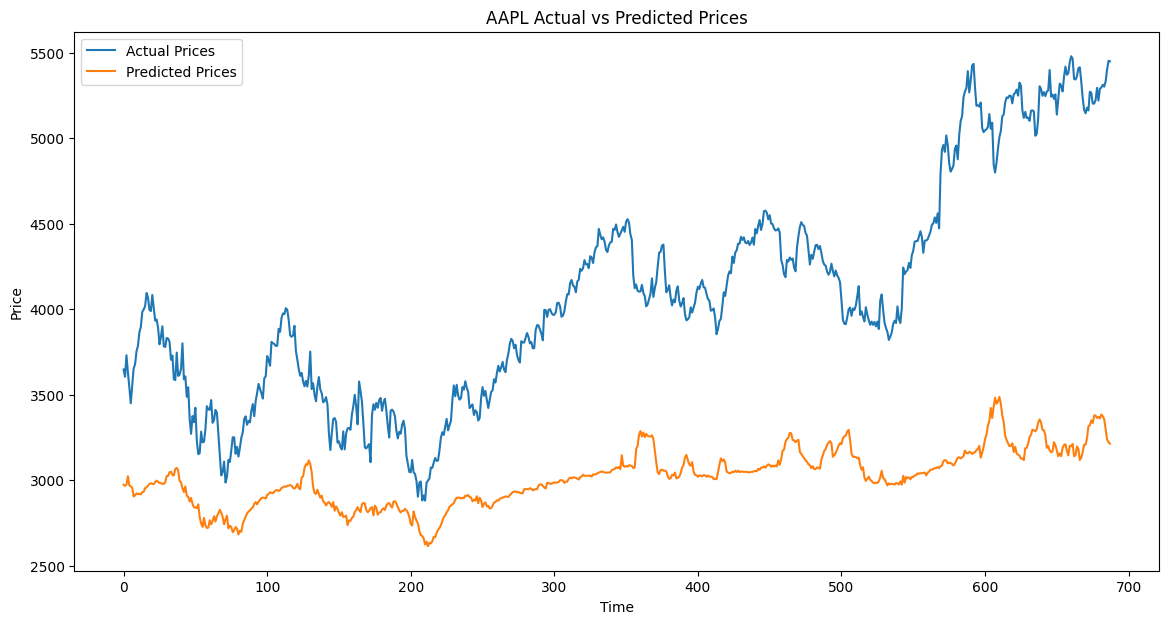

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import torch

# Load the best model
model.load_state_dict(torch.load(f'best_model_{ticker}.pth'))
model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate all batches
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# Invert scaling
predictions = target_scaler.inverse_transform(predictions)
actuals = target_scaler.inverse_transform(actuals)

# Calculate Mean Absolute Error on the original scale
mae = mean_absolute_error(actuals, predictions)
print(f'Mean Absolute Error on Test Set: {mae:.4f}')

# Plot Actual vs Predicted Prices
plt.figure(figsize=(14,7))
plt.plot(actuals, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [47]:
# Inspecting Actual vs. Predicted Values
num_samples = 10  # Number of samples to inspect
indices = np.random.choice(len(actuals), num_samples, replace=False)

print("Index\tActual\tPredicted\tDifference")
for idx in indices:
    actual = actuals[idx][0]
    predicted = predictions[idx][0]
    difference = actual - predicted
    print(f"{idx}\t{actual:.2f}\t{predicted:.2f}\t\t{difference:.2f}")


Index	Actual	Predicted	Difference
199	130.99	114.45		16.54
253	149.25	130.13		19.12
316	179.21	143.55		35.66
299	170.78	144.17		26.61
383	174.65	138.96		35.69
35	154.47	126.98		27.49
479	185.95	141.74		44.21
200	130.92	114.54		16.39
341	192.53	144.23		48.30
361	178.35	135.98		42.37


## 12. Backtesting the Trading Strategy (Broken)

We'll backtest a simple trading strategy based on the model's predictions:
- **Strategy**:
  - **Buy** if the predicted price > current close price.
  - **Sell** (short) if the predicted price ≤ current close price.

We'll compare the cumulative returns of this strategy against the market's performance.


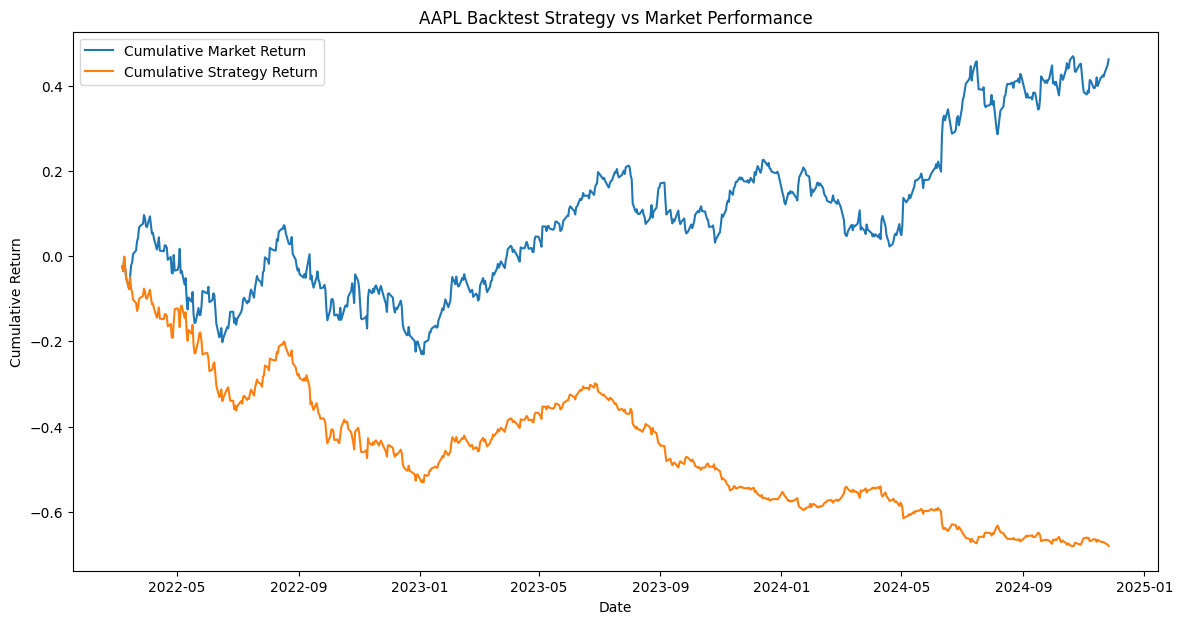

In [45]:
# Align test data with predictions
test_data_aligned = test_data.iloc[sequence_length:].copy()
test_data_aligned['Predicted'] = predictions.flatten()

# Calculate daily returns
test_data_aligned['Return'] = test_data_aligned['Close'].pct_change()

# Define the strategy: Buy if Predicted Price > Current Close, else Sell
test_data_aligned['Strategy'] = np.where(test_data_aligned['Predicted'] > test_data_aligned['Close'], test_data_aligned['Return'], -test_data_aligned['Return'])

# Calculate cumulative returns
test_data_aligned['Cumulative Market Return'] = (1 + test_data_aligned['Return']).cumprod() - 1
test_data_aligned['Cumulative Strategy Return'] = (1 + test_data_aligned['Strategy']).cumprod() - 1

# Plot the backtest results
plt.figure(figsize=(14,7))
plt.plot(test_data_aligned['Cumulative Market Return'], label='Cumulative Market Return')
plt.plot(test_data_aligned['Cumulative Strategy Return'], label='Cumulative Strategy Return')
plt.title(f"{ticker} Backtest Strategy vs Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()


## 13. Calculating Value at Risk (VaR)

Value at Risk (VaR) measures the potential loss in the portfolio over a defined period for a given confidence interval.

We'll calculate VaR for both the market and the strategy.


In [34]:
# Function to calculate Value at Risk (VaR)
def calculate_var(returns, confidence_level=0.95):
    var = np.percentile(returns.dropna(), (1 - confidence_level) * 100)  # Calculate percentile for VaR
    return var

# Calculate VaR for the strategy
var_strategy = calculate_var(test_data_aligned['Strategy'], confidence_level=0.95)
print(f"Value at Risk (VaR) for the Strategy: {var_strategy:.4f}")

# Calculate VaR for the market
var_market = calculate_var(test_data_aligned['Return'], confidence_level=0.95)
print(f"Value at Risk (VaR) for the Market: {var_market:.4f}")


Value at Risk (VaR) for the Strategy: -0.0283
Value at Risk (VaR) for the Market: -0.0283


## 14. Portfolio Optimization Using Markowitz Model (Optional)

If you're dealing with multiple assets, you can perform portfolio optimization to balance returns and risk. We'll use the Markowitz model to determine the optimal weights of assets in a portfolio.

**Note**: This is an extension and assumes you have expected returns and covariance matrices for your assets.


In [35]:
# Function for portfolio optimization using Markowitz model
def portfolio_optimization(expected_returns, covariance_matrix, target_return):
    def portfolio_volatility(weights, covariance_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))  # Portfolio volatility

    n_assets = len(expected_returns)
    args = (covariance_matrix,)
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights must sum to 1
        {'type': 'eq', 'fun': lambda weights: np.dot(weights, expected_returns) - target_return}  # Target return
    )
    bounds = tuple((0, 1) for _ in range(n_assets))  # Weights between 0 and 1
    initial_weights = n_assets * [1. / n_assets,]
    result = minimize(portfolio_volatility, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Example portfolio optimization
# Suppose we have 3 assets with the following expected returns and covariance matrix
expected_returns = np.array([0.10, 0.12, 0.15])  # Example expected returns
cov_matrix = np.array([
    [0.2, 0.1, 0.1],
    [0.1, 0.3, 0.15],
    [0.1, 0.15, 0.25]
])  # Example covariance matrix
target_return = 0.12

portfolio = portfolio_optimization(expected_returns, cov_matrix, target_return)
print("Optimized Portfolio Weights:", portfolio.x)


Optimized Portfolio Weights: [0.49126035 0.18123275 0.3275069 ]


## 15. Saving and Loading the Model (Optional)

After training, it's a good practice to save the model for future use without retraining.

We'll demonstrate how to save and load the PyTorch model.


In [36]:
# Save the model
torch.save(model.state_dict(), f"{ticker}_lstm_model.pth")
print(f"Model saved as {ticker}_lstm_model.pth")

# # Load the model
# loaded_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
# loaded_model.load_state_dict(torch.load(f"{ticker}_lstm_model.pth"))
# loaded_model = loaded_model.to(device)
# loaded_model.eval()
# print("Model loaded successfully.")


Model saved as AAPL_lstm_model.pth


## 16. Summary and Next Steps

### **Summary**

- **Data Acquisition**: Fetched historical stock data using `yfinance`.
- **Feature Engineering**: Added financial ratios and technical indicators to enhance predictive power.
- **Data Preparation**: Created sequences suitable for LSTM input and split data into training and testing sets.
- **Model Building**: Defined and trained an LSTM model using PyTorch.
- **Evaluation**: Assessed model performance using MAE and visualized predictions.
- **Backtesting**: Simulated a trading strategy based on model predictions and compared it with market performance.
- **Risk Assessment**: Calculated Value at Risk (VaR) for both the strategy and the market.
- **Portfolio Optimization**: (Optional) Demonstrated portfolio optimization using the Markowitz model.

### **Next Steps**

1. **Hyperparameter Tuning**:
   - Experiment with different `hidden_size`, `num_layers`, `sequence_length`, and learning rates to improve model performance.

2. **Advanced Feature Engineering**:
   - Incorporate additional technical indicators, sentiment analysis from news or social media, or macroeconomic factors.

3. **Model Enhancements**:
   - Implement more sophisticated architectures like Bidirectional LSTMs, GRUs, or Transformer-based models.

4. **Cross-Validation**:
   - Implement time series cross-validation to better assess model robustness.

5. **Deployment**:
   - Deploy the trained model as an API or integrate it into a trading system for real-time predictions.

6. **Risk Management**:
   - Incorporate more comprehensive risk management techniques beyond VaR, such as Conditional VaR or stress testing.

7. **Multi-Asset Modeling**:
   - Extend the model to handle multiple assets simultaneously for portfolio-level predictions.

### **Disclaimer**

Stock market prediction involves significant uncertainty and risk. While machine learning models like LSTM can aid in analyzing data and identifying patterns, they **cannot guarantee accurate predictions**. Always exercise caution and consider consulting financial professionals before making investment decisions.
